---
layout: post
title:  "Bayesian Linear Regression in Python"
desc: "A tutorial from creating data to plotting confidence intervals."
date: 2019-07-27
categories: [blog]
tags: [tutorial]
loc: 'blog/bayesianlinearregression/'
math: true
---

!!!replace

Bayesian linear regression is a common topic, but allow me to put my own spin on it. We'll start at generating some data, defining a model, fitting it and plotting the results. It shouldn't take long.

## Generating Data

Let's start by generating some experimental data. For simplicity, let us assume some underlying process generates samples $f(x) = mx + c$ and our observations have some given Gaussian error $\sigma$.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
num_points = 100
m, c = np.tan(np.pi / 4), -1
xs = np.random.uniform(size=num_points) * 10 + 2
ys = m * xs + c
err = np.sqrt(ys)
ys += err * np.random.normal(size=num_points)

In [24]:
# Remove
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['hist.bins'] = 50
plt.rcParams['lines.markersize'] = 2
from cycler import cycler	  
# plt.rcParams['axes.prop_cycle'] = (cycler(color=['#56d870', '#f9ee4a', '#44d9ff', '#f95b4a', '#3d9fe2', '#ffa847', '#c4ef7a', '#e195e2', '#ced9ed', '#fff29b']) + cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']))
plt.rcParams['axes.prop_cycle'] = (cycler(color=['#116A71', '#48AB75', '#b7c742', '#3d9fe2', '#ffa847', '#c4ef7a', '#e195e2', '#ced9ed', '#fff29b']) + cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':', '-.', '-']))

Now, let's plot our generated data to make sure it all looks good.

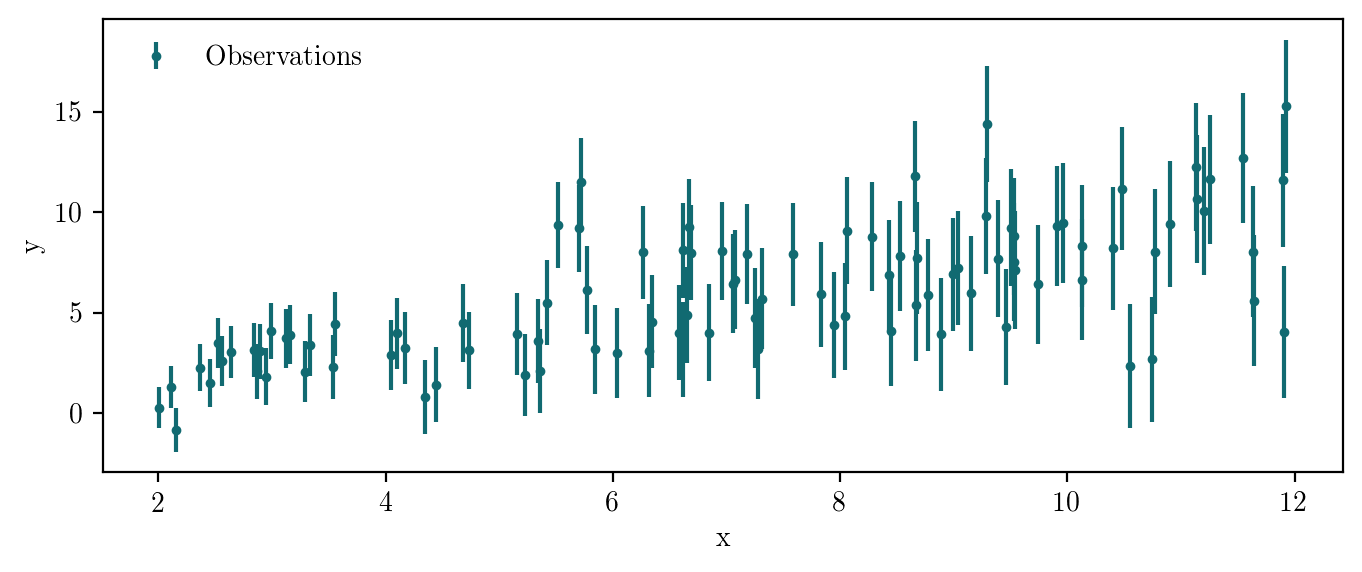

In [36]:
fig, ax = plt.subplots(figsize=(8,3))
ax.errorbar(xs, ys, yerr=err, fmt='.', label="Observations", ms=5)
ax.legend(frameon=False, loc=2)
ax.set_xlabel("x")
ax.set_ylabel("y");

## Defining a model

So, let's recall Bayes' theorem for a second:

$$ P(\theta | d) \propto P(d|\theta)P(\theta), $$

where $\theta$ is our model parametrisation and $d$ is our data. To sub in nomenclature, our posterior is proportional to our likelihood multiplied by our prior. So, we need to come up with a model to describe data, which one would think is fairly straightforward, given we just coded a model to *generate* our data. But before we jump the gun and code up $y = mx + c$, let us also consider the model $y = \tan(\phi) x + c$. Why would we care about whether we use a gradient or an angle? Well, it comes down to simplifying our prior - in our case with no background knowledge we'd want to sample all of our parameter space with the same probability. But what happens if we plot uniform probability in the two separate models?

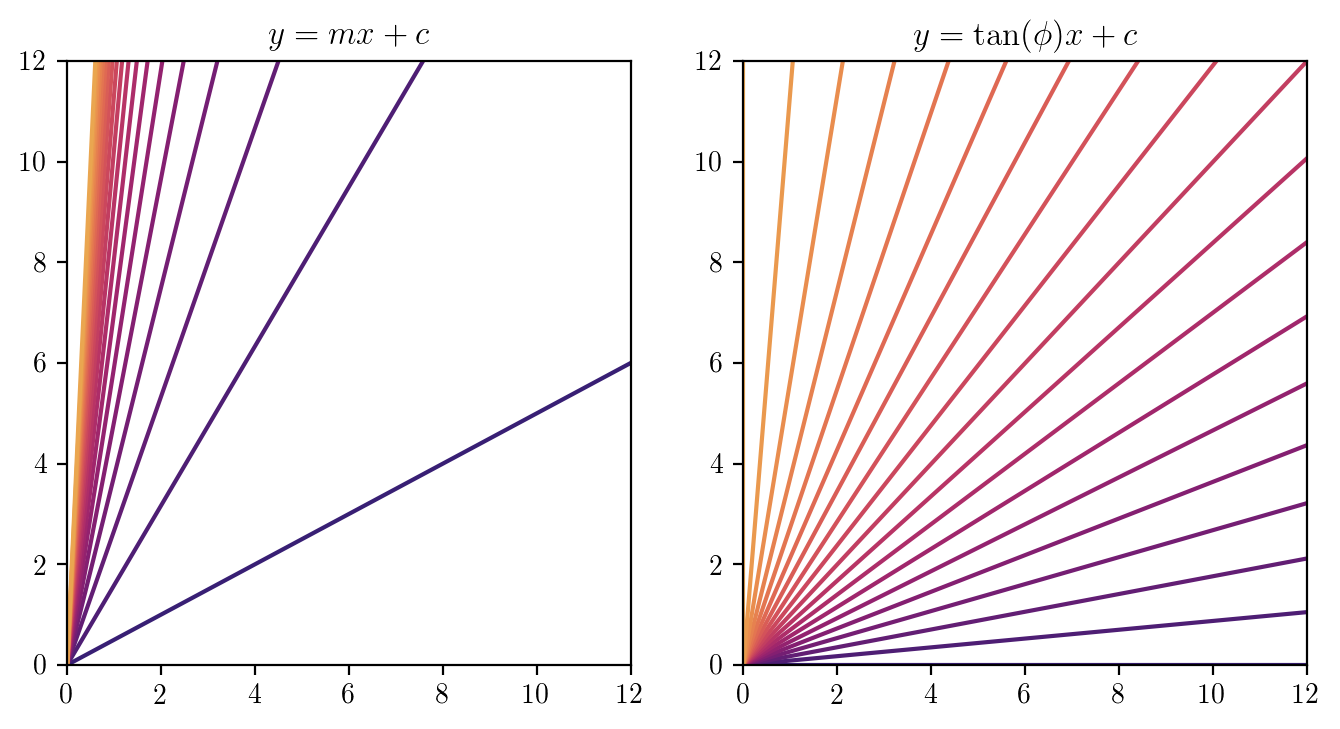

In [26]:
# Remove
fig, axes = plt.subplots(ncols=2)
x = np.linspace(0, 12, 10)
ms = np.linspace(0.5, 20, 19)
thetas = np.linspace(0, np.pi/2, 19)
cs = ["#381f74","#4e1e74","#621e74","#741e73","#841f71","#93226f","#a0266c","#ad2d69","#b83465","#c23e61","#cb475d","#d3525a","#d95d56","#df6953","#e37551","#e6814f","#e98d4e","#ea994e","#eaa650"]
for i, (m, t) in enumerate(zip(ms, thetas)):
    axes[0].plot(x, m * x, c=cs[i], lw=1.5, ls="-")
    axes[1].plot(x, np.tan(t) * x, c=cs[i], lw=1.5, ls="-")
    if i == 0:
        axes[0].set_title("$y = mx + c$")
        axes[1].set_title(r"$y = \tan(\phi) x + c$")
for a in axes:
    a.set_xlim(0, 12)
    a.set_ylim(0, 12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

Now it seems to me that uniformly sampling the angle, rather than the gradient, gives us an even distribution of coverage over our observational space.

So, if we lock in that model, we have two parameters of interest: $\theta = \lbrace \phi, c \rbrace$. Next up, we should think about the priors on those two parameters. Luckily, with the little investigation we did before, we can comfortably set flat (uniform) priors on both $\phi$ and $c$ and they will be non-informative. Aka, they will not contribute at all to our fitting locations. Note that we could have pursued the model parametrised by gradient, and simply given a non-uniform prior, but this way is easier. More formally, we have that:

$$ P(\phi) = U(-\frac{\pi}{2}, \frac{\pi}{2}) \\
P(c) = U(-\infty, \infty) $$

Where yes, we're working in radians. In code, this is also as simple:

In [27]:
def log_prior(xs):
    phi, c = xs
    if np.abs(phi) > np.pi / 2:
        return -np.inf
    return 0

Notice we don't even care about $c$ at all in the code, it can be any value, and the prior is constant over that value. And because Bayes' theorem only cares about proportionality, if it doesn't change, we don't worry about it. We only care about $\phi$'s boundary conditions for the same reasons, and when it crosses the boundary to a location we say it can't go, we return $-\infty$, which - as this is the log prior, is the same as saying probability zero. It can't happen.

As a note, we always work in log probability space, not probability space, because the numbers tend to span vast orders of magnitude.

Now we have the likelihood function $P(d\|\theta)$ to think about. If we take the errors as normally distributed (which we know they are), we can write down


$$ P(d_i|\theta) = \mathcal{N}\left( \frac{y_{i}-[\tan(\phi) x_{i} + c]}{\sigma_{i}}\right), $$

where $\mathcal{N}$ is the unit normal. This makes the assumption our observations are independent, which holds for this case. Note here that the equation is for a single data point. For a dataset, we would want this for each point:

$$ P(d|\theta) = \prod_i \mathcal{N}\left( \frac{y_{i}-[\tan(\phi) x_{i} + c]}{\sigma_{i}}\right). $$

When working in log space, this product simply becomes a sum. Writing out this equation is normally the hard part, implementing it in code is simple:

In [28]:
from scipy.stats import norm
def log_likelihood(xs, data):
    phi, c = xs
    xobs, yobs, eobs = data
    model = np.tan(phi) * xobs + c
    diff = model - yobs
    return norm.logpdf(diff / eobs).sum()

And now we want a function that gets the log posterior, by combining the prior and likelihood. Notice that if the prior comes back as an impossible value, we won't waste time computing the likelihood, we'll just return straight away.

In [29]:
def log_posterior(xs, data):
    prior = log_prior(xs)
    if not np.isfinite(prior):
        return prior
    return prior + log_likelihood(xs, data)

With that, our model is fully defined. We can now try and fit it to the data to see how we go.

## Model Fitting

There are so many ways of doing this. Using some MCMC algorithm, using nested sampling, other algorithms... too many options. Initially I wanted to do this example using `dynesty` - a new nested sampling package for python. But I realised, better to start off with the simpler `emcee` implementation to begin with. `emcee` is an affine-invariant MCMC sampler, and if you want more detail on that, [check out its documentation](https://emcee.readthedocs.io/en/latest/), let's just jump into how you'd use it.

In [30]:
import emcee
ndim = 2  # How many parameters we are fitting
nwalkers = 50  # Keep this well above your dimensionality.
p0 = np.random.uniform(low=-1.5, high=1.5, size=(nwalkers, ndim))  # Start points
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[(xs, ys, err)])
state = sampler.run_mcmc(p0, 3000)  # Tell each walker to take 2000 steps
chain = sampler.chain[:, 100:, :]  # Throw out the first hundred steps
flat_chain = chain.reshape((-1, ndim))  # Stack the steps from each walker 

So let's break this down. `ndim` is the number of parameters we have to fit, and we want to make sure that we have multiple times this for our `nwalkers` value, where each walker is a tracked position in parameter space that gets explored in a probabilistic fashion. I usually make sure there are a minimum of thirty or so walkers, but the more the merrier.

Next up, `p0` - each walker in the process needs to start somewhere! In this case, we pick a random position, it'll move from this quickly. We then make the `sampler`, and tell each walker in the sampler to take 1000 steps. The walkers should move around the parameter space in a way thats informed by the posterior (given our data). Now, the initial phase where the walkers move from the random positions we set to exploring the space properly is known as burn in, and we want to get rid of it, so we throw out the first 100 of the 1000 steps. How many you throw out depends on your problem, see the `emcee` documentation for more discussion on this, or just keep reading. Finally, we take the 3D chain (num walkers x num steps x num dimensions) and squish it down to 2D.

## Interpreting chains

So, we have this "chain" thing back from the sampler. The important thing to know is that an MCMC samples areas in parameter space proportional to their probability. So a point in $\phi-c$ space which is twice as likely as another will have twice as many samples. There are libraries you can use where you throw in those samples and it will crunch the numbers for you and give you constraints on your parameters. We'll be using one I made, called `ChainConsumer`. 

Let's check the state of the burn in removal:

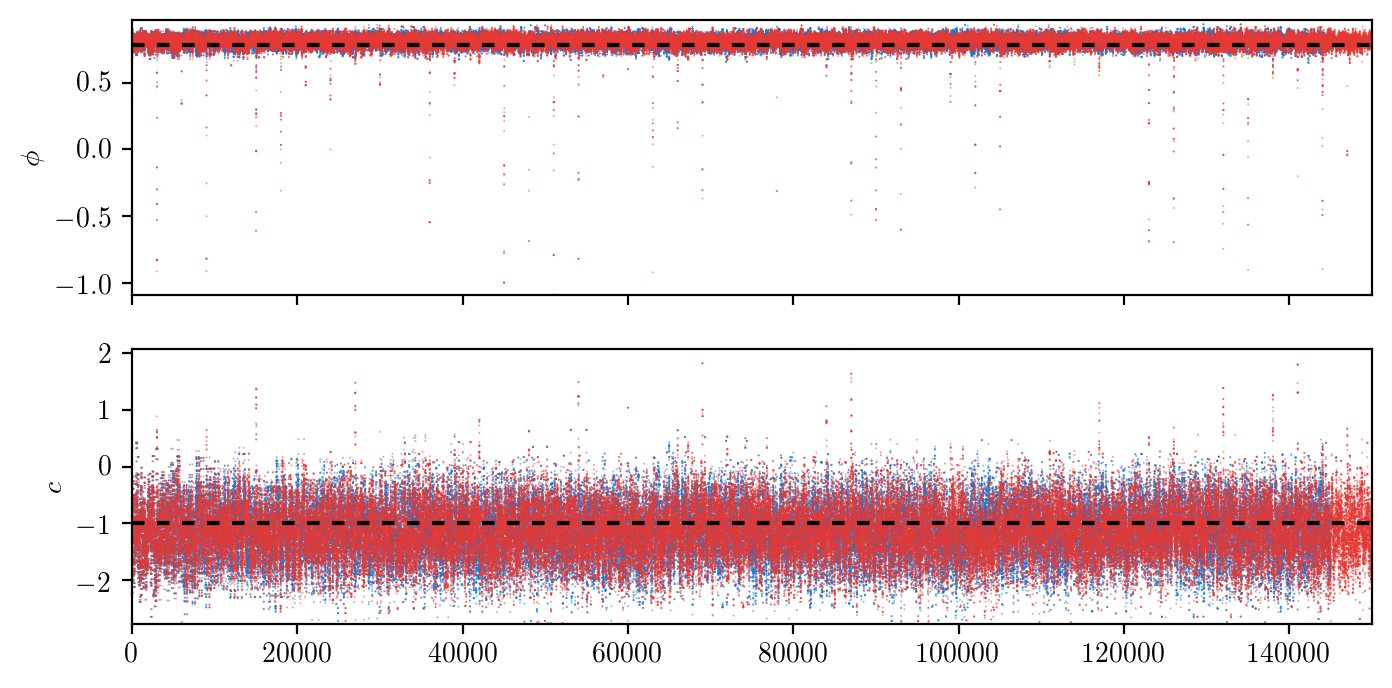

In [31]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(flat_chain, parameters=[r"$\phi$", "$c$"], color="b")
c.add_chain(sampler.chain.reshape((-1, ndim)), color="r")
c.plotter.plot_walks(truth=[np.pi/4, -1], figsize=(8,4));

So here we can see the walks plotted, also known as a trace plot. The blue contains all the samples from the chain we removed the burn in from, and the red doesn't have it removed. Notice all the little ticks in $\phi$ and $c$ - thats the random position of each walker (there will be fifty ticks, one for each walker) as they quickly converge to the right area of parameter space. The fact we don't see this in the blue means we've probably removed all burn in. There are diagnostics to check this in `ChainConsumer` too, but its not needed for this simple example.

Up next - let's get actual parameter constraints from this!

$\phi$   [0.7790342803201921, 0.8196328080383966, 0.851012206049082]
$c$   [-1.5984878536180744, -1.1973686828716112, -0.6860708557827717]


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


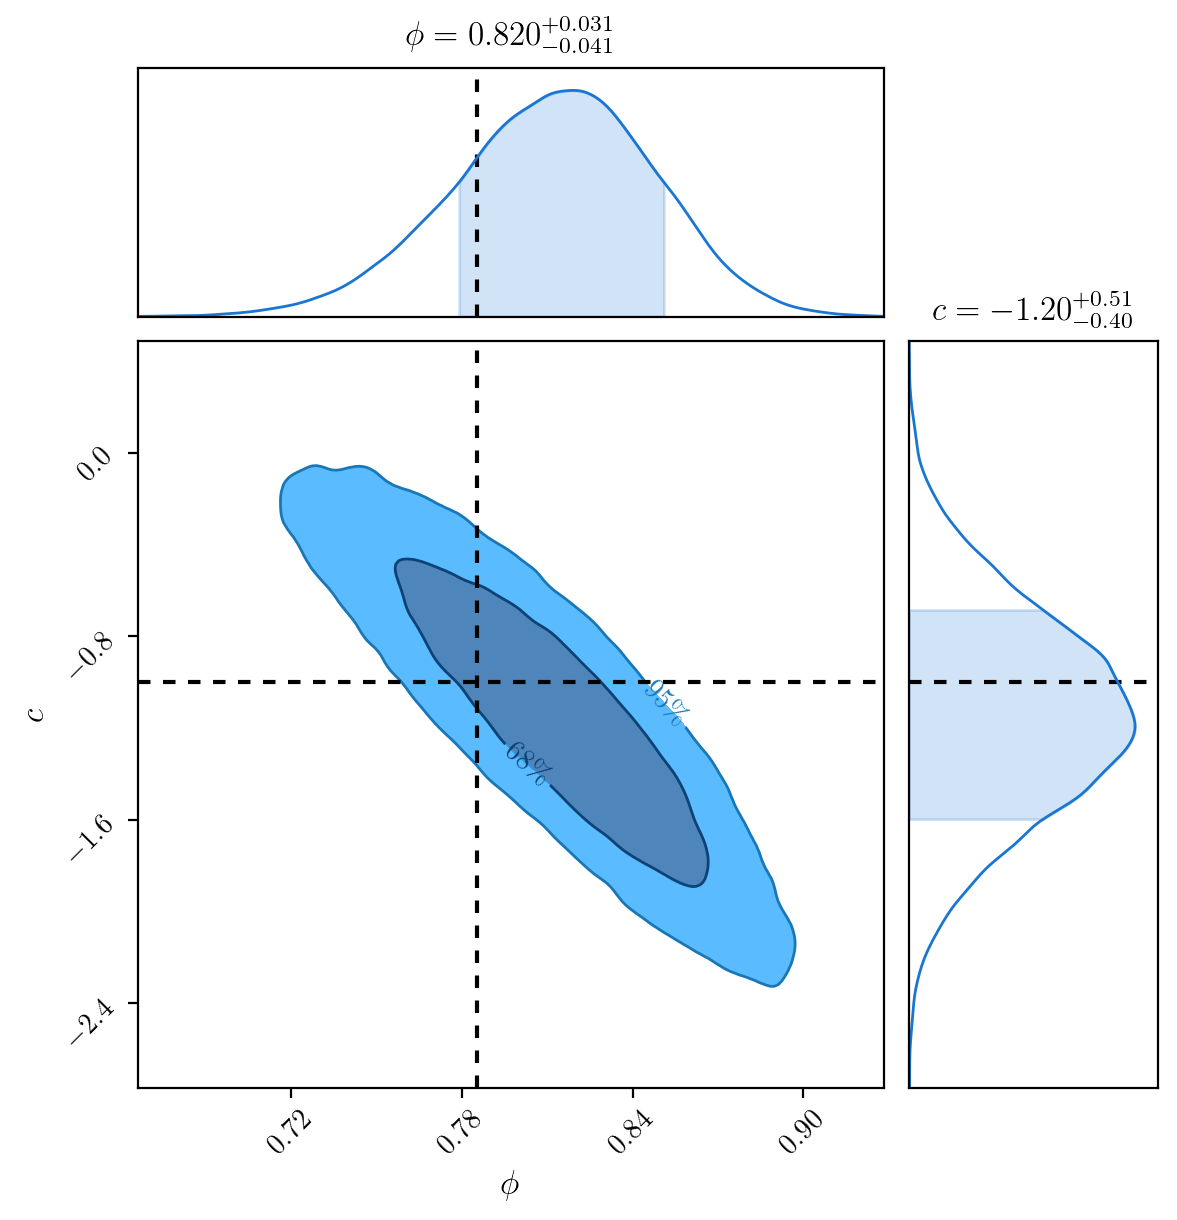

In [32]:
c = ChainConsumer()
c.add_chain(flat_chain, parameters=[r"$\phi$", "$c$"])
c.configure(contour_labels="confidence")
c.plotter.plot(truth=[np.pi/4, -1], figsize=2.0)
summary = c.analysis.get_summary()
for key, value in summary.items():
    print(key, " ", value)

So how do we read this? Well, if you look at the summary printed, that gives the bounds for the lower uncertainty, maximum value, and upper uncertainty respectively (uncertainty being the 68% confidence levels). In the actual plot, you can see a 2D surface which represents our posterior. For example, the inner circle, labelled 68%, says that 68% of the time the true value for $\phi$ and $c$ will lie in that contour. 95% of the time it will lie in the broader contour. 

Finally, one thing we might want to do is to plot the best fitting model and its uncertainty against our data. The best fit part is easy, its the uncertainty on our model that is the trickier part. What we'll do is sample from our chain over a variety of x-values to determine the effect our parameter uncertainty has in observational space. Easier to do than explain.


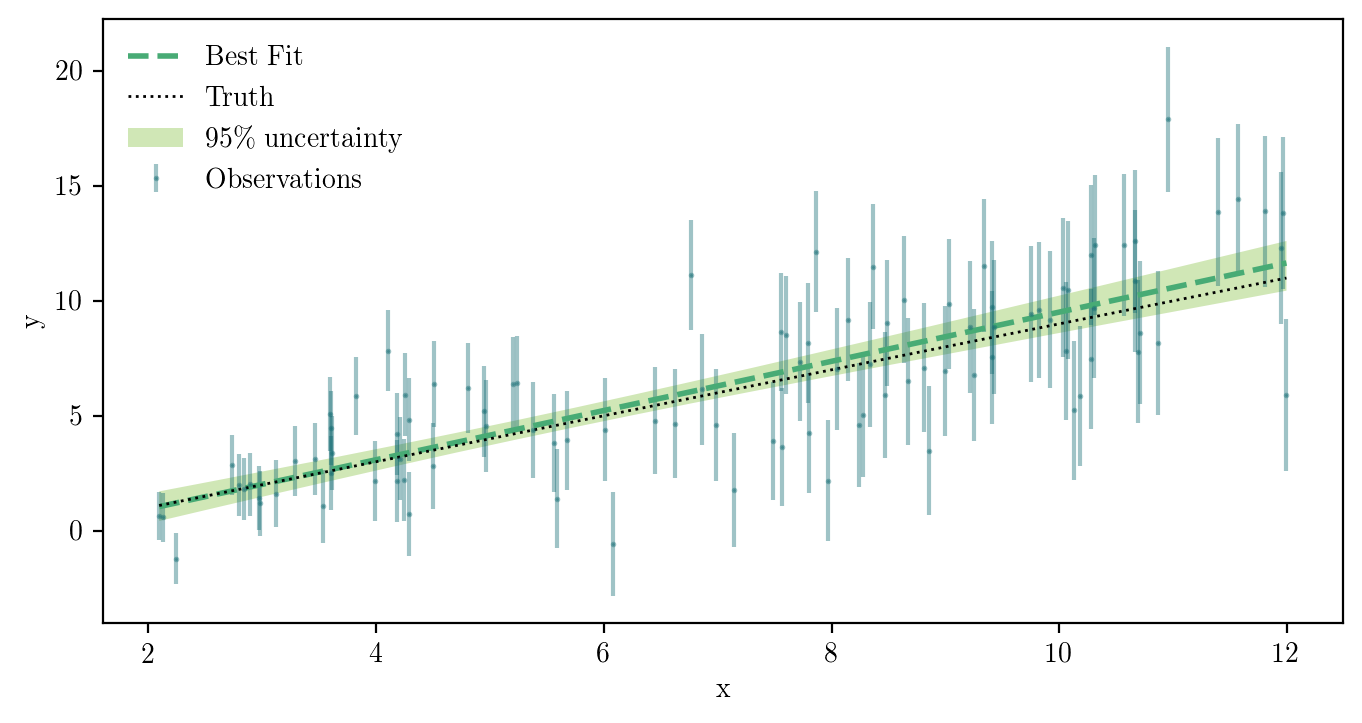

In [33]:
x_vals = np.linspace(xs.min(), xs.max(), 20)
# Calculate best fit
phi_best = summary[r"$\phi$"][1]
c_best = summary[r"$c$"][1]
best_fit = np.tan(phi_best) * x_vals + c_best

# Calculate range our uncertainty gives using 2D matrix multplication
realisations = np.tan(flat_chain[:, 0][:, None]) * x_vals + flat_chain[:, 1][:, None]
bounds = np.percentile(realisations, 100 * norm.cdf([-2, 2]), axis=0)

# Plot everything
fig, ax = plt.subplots()
ax.errorbar(xs, ys, yerr=err, fmt='.', label="Observations", alpha=0.4)
ax.plot(x_vals, best_fit, label="Best Fit", lw=2)
ax.plot(x_vals, x_vals - 1, label="Truth", c="k", ls=":", lw=1)
plt.fill_between(x_vals, bounds[0, :], bounds[1, :], 
                 label="95\% uncertainty", fc="#8BC34A", alpha=0.4)
ax.legend(frameon=False, loc=2)
ax.set_xlabel("x")
ax.set_ylabel("y");

!!!main

Notice how even with a linear model, our uncertainty is not just linear, it is smallest in the center of the dataset, as we might expect if we imagine the fit rocking the line like a see-saw during the fitting process. To reiterate, what we did to calculate the uncertainty was - instead of using some summary of the uncertainty like the standard deviation - we used the entire posterior surface to generate thousands of models, and looked at their uncertainty (using the `percentile`) function to get the $2\sigma$ bounds (the `norm.cdf` part) to display on the plot.


And that's it, those are the basics.

1. Define your model, think about parametrisation, priors and likelihoods
2. Create a sampler and sample your parameter space
3. Determine parameter constraints from your samples.
4. Plot everything.

Putting all the code in one place for convenience:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import emcee
from scipy.stats import norm

# Define data
num_points = 100
m, c = np.tan(np.pi / 4), -1
xs = np.random.uniform(size=num_points) * 10 + 2
ys = m * xs + c
err = np.sqrt(ys)
ys += err * np.random.normal(size=num_points)

def log_prior(xs):
    phi, c = xs
    if np.abs(phi) > np.pi / 2:
        return -np.inf
    return 0

def log_likelihood(xs, data):
    phi, c = xs
    xobs, yobs, eobs = data
    model = np.tan(phi) * xobs + c
    diff = model - yobs
    return norm.logpdf(diff / eobs).sum()

def log_posterior(xs, data):
    prior = log_prior(xs)
    if not np.isfinite(prior):
        return prior
    return prior + log_likelihood(xs, data)

# Sample model
ndim = 2  # How many parameters we are fitting
nwalkers = 50  # Keep this well above your dimensionality.
p0 = np.random.uniform(low=-1.5, high=1.5, size=(nwalkers, ndim))  # Start points
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[(xs, ys, err)])
state = sampler.run_mcmc(p0, 3000)  # Tell each walker to take 2000 steps
chain = sampler.chain[:, 100:, :]  # Throw out the first hundred steps
flat_chain = chain.reshape((-1, ndim))  # Stack the steps from each walker 

# Plot parameter constraints
c = ChainConsumer()
c.add_chain(flat_chain, parameters=[r"$\phi$", "$c$"])
c.configure(contour_labels="confidence")
c.plotter.plot(truth=[np.pi/4, -1], figsize=2.0)
summary = c.analysis.get_summary()
for key, value in summary.items():
    print(key, " ", value)
    
# Map back onto observational space for visualisation
x_vals = np.linspace(xs.min(), xs.max(), 20)
# Calculate best fit
phi_best = summary[r"$\phi$"][1]
c_best = summary[r"$c$"][1]
best_fit = np.tan(phi_best) * x_vals + c_best

# Calculate range our uncertainty gives using 2D matrix multplication
realisations = np.tan(flat_chain[:, 0][:, None]) * x_vals + flat_chain[:, 1][:, None]
bounds = np.percentile(realisations, 100 * norm.cdf([-2, 2]), axis=0)

# Plot everything
fig, ax = plt.subplots()
ax.errorbar(xs, ys, yerr=err, fmt='.', label="Observations", alpha=0.4)
ax.plot(x_vals, best_fit, label="Best Fit", lw=2)
ax.plot(x_vals, x_vals - 1, label="Truth", c="k", ls=":", lw=1)
plt.fill_between(x_vals, bounds[0, :], bounds[1, :], 
                 label="95\% uncertainty", fc="#8BC34A", alpha=0.4)
ax.legend(frameon=False, loc=2)
ax.set_xlabel("x")
ax.set_ylabel("y");